In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import seaborn as sns
import pandas as pd

In [ ]:
# x-coordinates of measured data
x_j = np.array([535,749,963,1177,1391,1605,1819,2033,2247,2461,2675,2889])

# observed data
d_obs = -1 * np.array([15.1,23.9,31.2,36.9,40.8,42.8,42.5,40.7,37.1,31.5,21.9,12.9])*10**(-5)

# half of the observed data 
d_obs_2 = -1 * np.array([23.9,36.9,42.8,40.7,31.5,12.9])*10**(-5)

In [ ]:
# number of model parameters
M = 12
# the glacier spans the interval [0,a]
a = 3420
#Gravitational constant
G = 6.67408*10**(-11)
drho = -1733 #difference in density between ice and rock [kg/m^3]


x = np.linspace(0,a,M+1)
x_left = x[:-1] # x-coordinates of the left sides of the columns
x_right = x[1:] # x-coordinates of the right sides of the columns
x = 1/2*(x_right+x_left) # The midpoints of all columns

h_0 = d_obs/(2*np.pi*G*drho) # Thickness of the ice layers

m0 = np.ones(M) # model parameter vector

#Loop that finds the h_0 that is closest to the given column center
for i in range(len(m0)):
  k = np.argmin(np.abs(x_j-x[i]))
  m0[i] = h_0[k]

# Covariance matrices
CM = np.diag(np.ones(M)*300**2) # A priori
CM_inv = np.linalg.inv(CM)
CD = np.diag(np.ones(len(d_obs))*(1.2*10**(-5))**2) # Data
CD_inv = np.linalg.inv(CD)

# The prior distribution as given in the assignment
def prior(m):
    return np.exp(-1/2*np.dot((m-m0),(m-m0))/300**2)

# gravity gradient anomaly
def dg(x_r,x_l,xj,h):
  return G*drho*  (( (x_r-xj)*np.log(1+h**2/(x_r-xj)**2)+2*h*np.arctan((x_r-xj)/h) ) - ((x_l-xj)*np.log(1+h**2/(x_l-xj)**2)+2*h*np.arctan((x_l-xj)/h)))
#def dg(x_r,x_l,xj,h):
#  return G*drho*  (( (x_r-xj)*np.log((h**2+x_r**2+x_j**2-2*x_r*x_j)/(x_r-xj)**2)+2*h*np.arctan((x_r-xj)/h) ) - ((x_l-xj)*np.log((h**2+x_l**2+x_j**2-2*x_l*x_j)/(x_l-xj)**2)+2*h*np.arctan((x_l-xj)/h)))


# gravity gradient
def g(m):
  d_est = np.zeros_like(d_obs)
  for j in range(len(d_obs)):
    d_est[j] = np.sum([dg(x_right[i],x_left[i],x_j[j],m[i]) for i in range(M)])
    #for i in range(M):
    #  d_est[j] += dg(x_right[i],x_left[i],x_j[j],m[i])
  return d_est


def minus_log_likelihood(m):
    return 1/2*np.dot((d_obs-g(m)),(d_obs-g(m))/(1.2*10**(-5))**2)


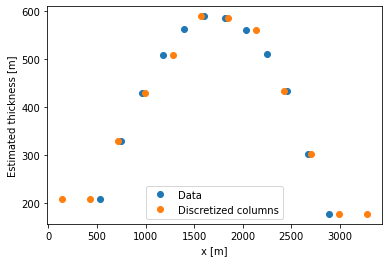

In [ ]:
plt.figure()
plt.plot(x_j,h_0,'o', label = "Data")
plt.plot(x,m0,'o', label = "Discretized columns")
plt.ylabel("Estimated thickness [m]")
plt.xlabel("x [m]")
plt.legend()

In [ ]:
def norm2(v):
  return np.sqrt(np.dot(v,v))
  
def S(m): # Misfit
  return 1/2*np.dot((m-m0),(m-m0))/300**2 + 1/2*np.dot((d_obs-g(m)),(d_obs-g(m))/(1.2*10**(-5))**2)

def posterior(m):
  return np.exp(-S(m))

def accept(m0, m1):
    if S(m1) > S(m0):
        p = np.exp(-(S(m1)-S(m0)))
    else:
        p = 1
    return p

In [ ]:
l = 100
# Function that takes a random step of length <=l
def rand_step(m,l):
  m=m.copy()
  i = np.random.randint(0,M)
  m_step = np.zeros_like(m)
  m_step[i] += np.random.uniform(-l,l)

  if (m + m_step)[i]< 1:
    m_step = np.zeros_like(m)

  return m_step

In [ ]:

def metropolis(N):
  m = m0
  models = np.zeros((N,M))
  number = np.arange(N)
  accepted_numbers = 0
  s_values = np.zeros(N)
  minloglik_values = np.zeros(N)

  for i in range(N):
    m_new = m+rand_step(m,l)
    p = accept(m,m_new)
    if np.random.uniform(0,1) <= p:
      m = m_new
      accepted_numbers += 1

    models[i,:] = m
    s_values[i] = S(m)
    minloglik_values[i] = minus_log_likelihood(m)
    if i %1000 ==0:
      print(f'iteration {i} complete')
  
  return number,models,s_values,accepted_numbers,minloglik_values

In [ ]:
number, models,s_values, accepted_numbers,minloglik_values = metropolis(10000)

iteration 0 complete
iteration 1000 complete
iteration 2000 complete
iteration 3000 complete
iteration 4000 complete
iteration 5000 complete
iteration 6000 complete
iteration 7000 complete
iteration 8000 complete
iteration 9000 complete


In [ ]:
rate = accepted_numbers/len(number)

if 0.3 > rate or rate >0.7:
  print('--Warning!-- Extreme acceptance rate:', rate)
else:
  print('Acceptance rate:', rate)

Acceptance rate: 0.6621


Estimated model parameters are [  50.12531646   78.27569671  139.29306458  596.96167583  734.07734933
  924.23289658  610.63282943 1373.32355249  522.87684837   45.26493901
   11.98270188  288.15114402]
0.44356268846279906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


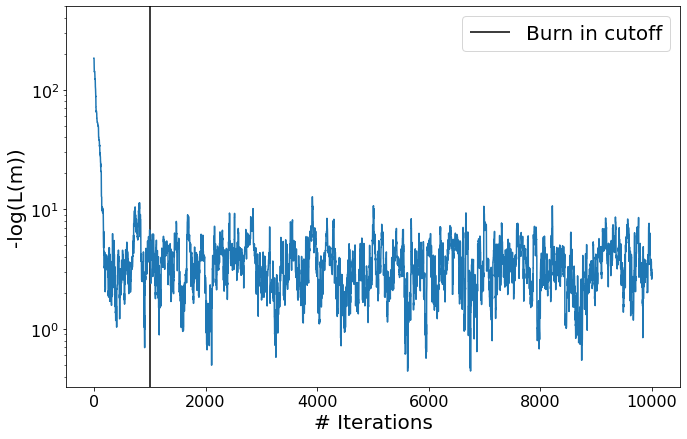

Estimated model parameters are [  50.12531646   78.27569671  139.29306458  596.96167583  734.07734933
  924.23289658  610.63282943 1373.32355249  522.87684837   45.26493901
   11.98270188  288.15114402]
0.44356268846279906


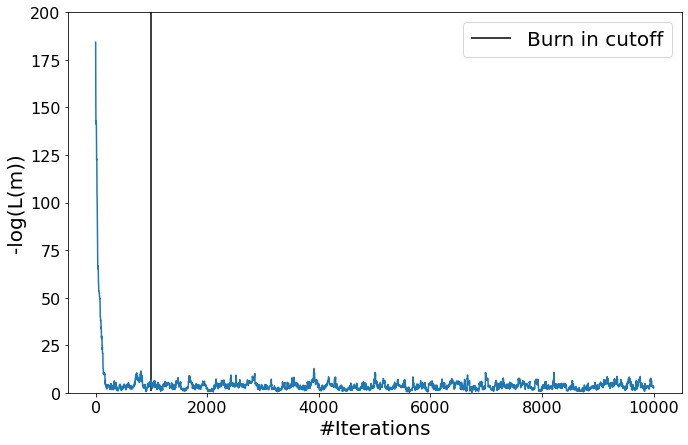

In [ ]:
plt.figure(figsize=(11,7))
plt.plot(number,minloglik_values)
print('Estimated model parameters are', models[-1,:])
plt.yscale('log')
plt.ylim(0,5*10**(2))
print(min(minloglik_values))
burnin_time = 1000
plt.xlabel('# Iterations',fontsize=20)
plt.ylabel('-log(L(m))',fontsize=20)
plt.vlines(burnin_time,0,10**3,label='Burn in cutoff')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


plt.figure(figsize=(11,7))
plt.plot(number,minloglik_values)
print('Estimated model parameters are', models[-1,:])
print(min(minloglik_values))
plt.ylim(0,200)
plt.xlabel('#Iterations',fontsize=20)
plt.ylabel('-log(L(m))',fontsize=20)
plt.vlines(burnin_time,1,200,label='Burn in cutoff')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [ ]:
print(models[-1,:])

[  50.12531646   78.27569671  139.29306458  596.96167583  734.07734933
  924.23289658  610.63282943 1373.32355249  522.87684837   45.26493901
   11.98270188  288.15114402]


In [ ]:
print(h_0)

[207.7816105  328.87288019 429.32359255 507.75771042 561.42315949
 588.9439026  584.81579114 560.04712234 510.50978473 433.45170402
 301.35213708 177.50879307]


In [ ]:
print(g(models[-1,:]))

[-0.00016887 -0.0002408  -0.00032116 -0.00037688 -0.00040828 -0.00042317
 -0.00042449 -0.00041211 -0.00038146 -0.00031938 -0.00020789 -0.00013794]


In [ ]:
print(d_obs)

[-0.000151 -0.000239 -0.000312 -0.000369 -0.000408 -0.000428 -0.000425
 -0.000407 -0.000371 -0.000315 -0.000219 -0.000129]


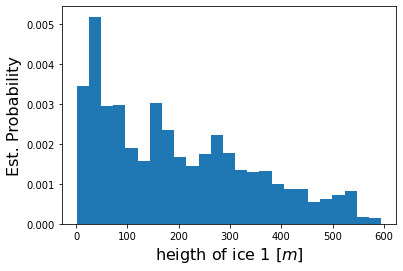

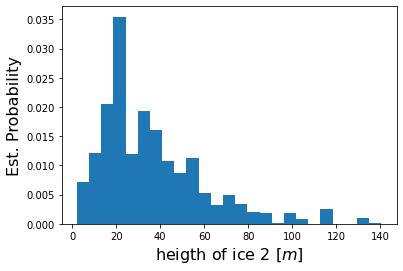

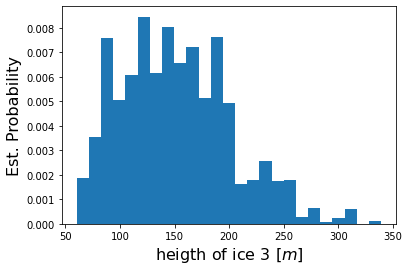

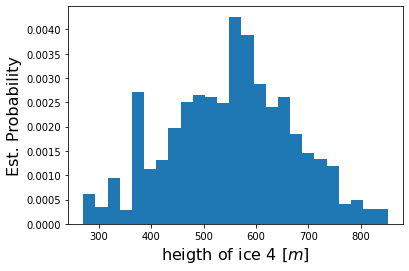

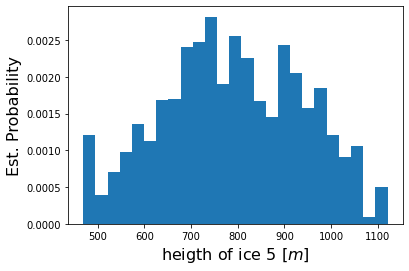

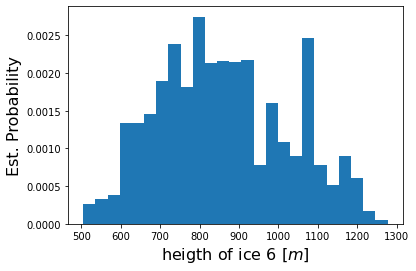

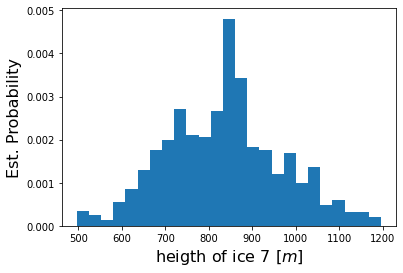

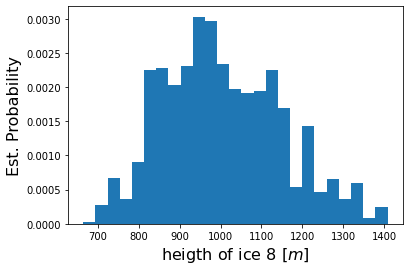

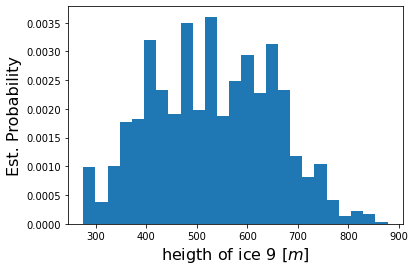

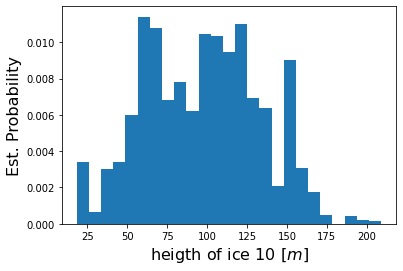

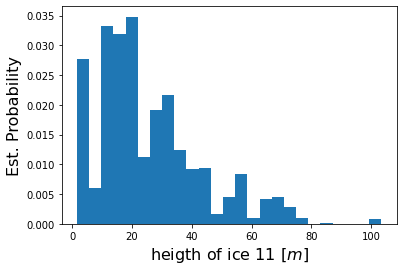

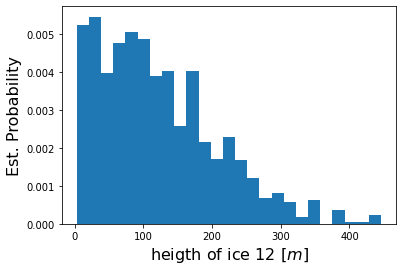

In [ ]:
for i in range(M):
  plt.figure()
  plt.hist(models[burnin_time:,i], density=False, bins=16)  # density=False would make counts
  plt.ylabel('# Counts',fontsize=16)
  plt.xlabel(f"Thickness of ice {i+1} [$m$]",fontsize=16);

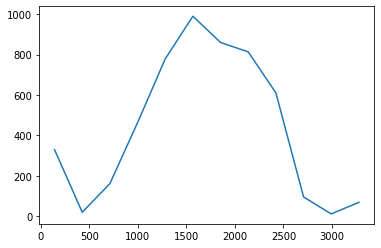

In [ ]:
print(x)
best = np.argmin(s_values)
plt.plot(x,models[best,:],'o', label = "MCMC")
#plt.plot(x_j,h_0,'o', label = "Data")
plt.plot(x,m0,'o', label = "Simple estimate")
plt.ylabel("Estimated thickness [m]")
plt.xlabel("x [m]")
plt.legend()

In [ ]:
plt.errorbar(x_j,d_obs*10**5,yerr=np.ones(12)*1.2,fmt='.',label ="d_obs")
plt.plot(x_j,g(models[best,:])*10**5,'o', label = "d_est - best fit")
plt.xlabel("x [m]")
plt.ylabel("Gravity anomaly [mgal]")
plt.legend()

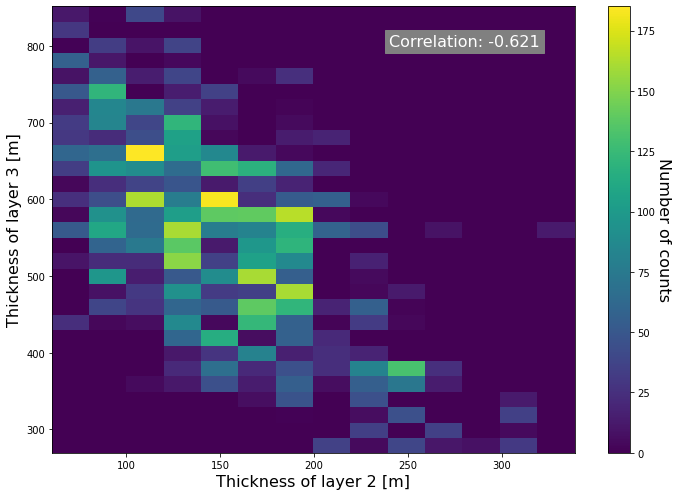

In [ ]:
Layer_A = 2
Layer_B = Layer_A + 1
# Creating dataset
x = models[burnin_time:,Layer_A]
y = models[burnin_time:,Layer_B]
  
# Creating bins
x_min = np.min(x)
x_max = np.max(x)
  
y_min = np.min(y)
y_max = np.max(y)
  
x_bins = np.linspace(x_min, x_max, 15)
y_bins = np.linspace(y_min, y_max, 30)
  
fig, ax = plt.subplots(figsize =(10, 7))
# Creating plot
plt.hist2d(x, y, bins =[x_bins, y_bins])
#h = ax.hist2d(x, y, bins =[x_bins, y_bins])

ax.set_xlabel(f'Thickness of layer {Layer_A} [m]',fontsize=16) 
ax.set_ylabel(f'Thickness of layer {Layer_B} [m]',fontsize=16) 

#im = ax.imshow(x,y)
#fig.colorbar(h, ax=ax)

cbar = plt.colorbar()
cbar.set_label('Number of counts', rotation=270, fontsize=16, labelpad=15)
plt.text(240,800, f'Correlation: {np.round(np.corrcoef(x,y)[1,0],3)}', c='white', fontsize=16, backgroundcolor='grey')
# show plot
plt.tight_layout()
plt.show()

In [ ]:
print('Correlation:',np.corrcoef(x,y)[1,0])

Correlation: -0.6214576615397933


# Now with half the data

In [ ]:
d_obs_2 = -1 * np.array([23.9,36.9,42.8,40.7,31.5,12.9])*10**(-5)
x_j_2 = np.array([749,1177,1605,2033,2461,2889])

In [ ]:
M = 12
a = 3420
G = 6.67408*10**(-11)
drho = -1733 #difference in density between ice and rock [kg/m^3]

x_2 = np.linspace(0,a,M+1)
x_left_2 = x_2[:-1]
x_right_2 = x_2[1:]
x_2 = 1/2*(x_right_2+x_left_2)

h_0_2 = d_obs_2/(2*np.pi*G*drho)

m0_2 = np.ones(M)
for i in range(len(m0_2)):
  k_2 = np.argmin(np.abs(x_j_2-x_2[i]))
  m0_2[i] = h_0_2[k_2]

# Covariance matrices
CM = np.diag(np.ones(M)*300**2) # A priori
CM_inv = np.linalg.inv(CM)
CD = np.diag(np.ones(len(d_obs))*(1.2*10**(-5))**2) # Data
CD_inv = np.linalg.inv(CD)

def prior_2(m):
    return np.exp(-1/2*np.dot((m-m0_2),(m-m0_2))/300**2)

def dg(x_r,x_l,xj,h):
  return G*drho*  (( (x_r-xj)*np.log(1+h**2/(x_r-xj)**2)+2*h*np.arctan((x_r-xj)/h) ) - ((x_l-xj)*np.log(1+h**2/(x_l-xj)**2)+2*h*np.arctan((x_l-xj)/h)))

def g_2(m):
  d_est = np.zeros_like(d_obs_2)
  for j in range(len(d_obs_2)):
    d_est[j] = np.sum([dg(x_right_2[i],x_left_2[i],x_j_2[j],m[i]) for i in range(M)])
    #for i in range(M):
    #  d_est[j] += dg(x_right[i],x_left[i],x_j[j],m[i])
  return d_est

def minus_log_likelihood_2(m):
    return 1/2*np.dot((d_obs_2-g_2(m)),(d_obs_2-g_2(m))/(1.2*10**(-5))**2)


In [ ]:
#plt.figure()
#plt.x
#plt.plot(x_j_2,h_0_2,'o')
#plt.plot(x_2,m0_2,'o')

In [ ]:
def norm2(v):
  return np.sqrt(np.dot(v,v))
  
def S_2(m): # Misfit
  return 1/2*np.dot((m-m0_2),(m-m0_2))/300**2 + 1/2*np.dot((d_obs_2-g_2(m)),(d_obs_2-g_2(m))/(1.2*10**(-5))**2)

def posterior_2(m):
  return np.exp(-S_2(m))

def accept_2(m0, m1):
    if S_2(m1) > S_2(m0):
        p = np.exp(-(S_2(m1)-S_2(m0)))
    else:
        p = 1
    return p

In [ ]:
l = 100
def rand_step(m,l):
  m=m.copy()
  i = np.random.randint(0,M)
  m_step = np.zeros_like(m)
  m_step[i] += np.random.uniform(-l,l)

  if (m + m_step)[i]< 1:
    m_step = np.zeros_like(m)

  return m_step

In [ ]:

def metropolis(N):
  m = m0_2
  models = np.zeros((N,M))
  number = np.arange(N)
  accepted_numbers = 0
  s_values = np.zeros(N)
  minloglik_values = np.zeros(N)

  for i in range(N):
    m_new = m+rand_step(m,l)
    p = accept_2(m,m_new)
    if np.random.uniform(0,1) <= p:
      m = m_new
      accepted_numbers += 1

    models[i,:] = m
    s_values[i] = S_2(m)
    minloglik_values[i] = minus_log_likelihood_2(m)
    if i %1000 ==0:
      print(f'iteration {i} complete')
  
  return number,models,s_values,accepted_numbers,minloglik_values

In [ ]:
number_2, models_2,s_values_2, accepted_numbers_2,minloglik_values_2 = metropolis(10000)

iteration 0 complete
iteration 1000 complete
iteration 2000 complete
iteration 3000 complete
iteration 4000 complete
iteration 5000 complete
iteration 6000 complete
iteration 7000 complete
iteration 8000 complete
iteration 9000 complete


Estimated model parameters are [  50.12531646   78.27569671  139.29306458  596.96167583  734.07734933
  924.23289658  610.63282943 1373.32355249  522.87684837   45.26493901
   11.98270188  288.15114402]
0.1345894680511872


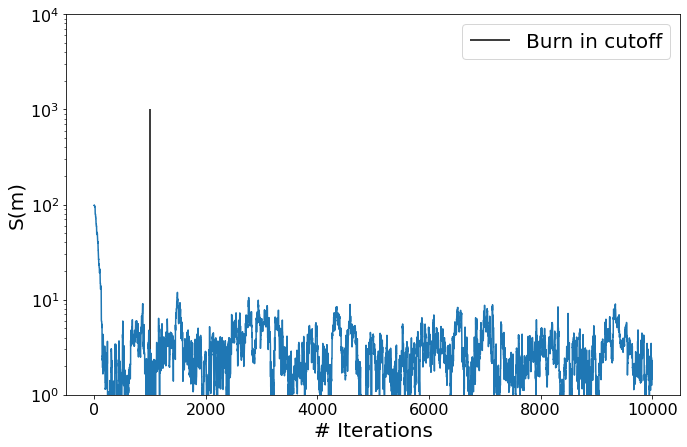

Estimated model parameters are [  50.12531646   78.27569671  139.29306458  596.96167583  734.07734933
  924.23289658  610.63282943 1373.32355249  522.87684837   45.26493901
   11.98270188  288.15114402]
0.1345894680511872


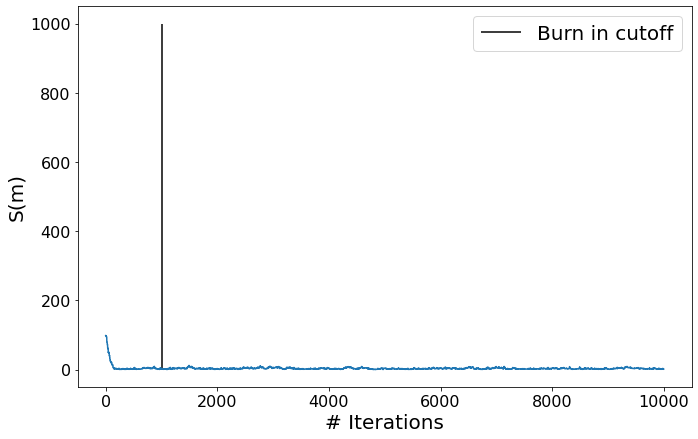

In [ ]:
plt.figure(figsize=(11,7))
plt.plot(number_2,minloglik_values_2)
print('Estimated model parameters are', models[-1,:])
plt.yscale('log')
plt.ylim(1,10**(4))
print(min(minloglik_values_2))
burnin_time = 1000
plt.xlabel('# Iterations',fontsize=20)
plt.ylabel('S(m)',fontsize=20)
plt.vlines(burnin_time,1,10**3,label='Burn in cutoff')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


plt.figure(figsize=(11,7))
plt.plot(number_2,minloglik_values_2)
print('Estimated model parameters are', models[-1,:])
print(min(minloglik_values_2))
plt.xlabel('# Iterations',fontsize=20)
plt.ylabel('S(m)',fontsize=20)
plt.vlines(burnin_time,1,10**3,label='Burn in cutoff')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [ ]:
k1 = len(models[burnin_time:,0])
m_lengths_1 = np.zeros(M)
for i in range(M):
  m_lengths_1[i] = np.max(models[burnin_time:,i]) - np.min(models[burnin_time:,i])
V1 = np.prod(m_lengths_1)
inv_post1 = [1/posterior(models[burnin_time:,:][i,:]) for i in range(len(models[burnin_time:,0]))]
const1 = 1/V1/k1*np.sum(inv_post1)


k2 = len(models_2[burnin_time:,0])
m_lengths_2 = np.zeros(M)
for i in range(M):
  m_lengths_2[i] = np.max(models_2[burnin_time:,i]) - np.min(models_2[burnin_time:,i])
V2 = np.prod(m_lengths_2)
inv_post2 = [1/posterior_2(models_2[burnin_time:,:][i,:]) for i in range(len(models_2[burnin_time:,0]))]
const2 = 1/V2/k2*np.sum(inv_post2)

In [ ]:
print(((300*3)**12)/(10**33))

282.429536481


In [ ]:
print('k1:',k1)
print('k2:',k2)
print(inv_post1)
print(np.sum(inv_post1))
print('Volume 1:', V1)
print('Volume 2:', V2)
print('Constant 1:',const1)
print('Constant 2:',const2)

k1: 9000
k2: 9000
[2958.2827206633483, 2958.2827206633483, 2385.152388859404, 1835.0619184158984, 1835.0619184158984, 2170.5245543888345, 2170.5245543888345, 2116.9996806322292, 3701.965102737575, 2675.489683508526, 1348.8808924054779, 1348.8808924054779, 1192.8966975229714, 1192.8966975229714, 1122.0559823710162, 1122.0559823710162, 542.3240668717639, 542.3240668717639, 4383.44769082828, 4220.889025320346, 2654.862226077413, 2596.5284048302024, 3927.7203424775844, 7418.406549432272, 8219.132846907198, 8219.132846907198, 8158.126416059922, 8158.126416059922, 8158.126416059922, 10596.773073754794, 10596.773073754794, 8218.785980640485, 3891.5742044980066, 3891.5742044980066, 5947.779850584247, 5920.971092605471, 2518.0034743289784, 2518.0034743289784, 2143.2842275338535, 7409.80741614278, 7433.01195326035, 11684.626568457017, 7650.224888690374, 4880.743056840304, 16788.442745970216, 16788.442745970216, 16788.442745970216, 13563.649114632122, 2181.331917322316, 2181.331917322316, 2138.08

In [ ]:
D = 0
for i in range(len(models[burnin_time:,0])):
  D += np.log2(const1*posterior(models[burnin_time+i,:])/(const2*posterior_2(models[burnin_time+i,:])))

In [ ]:
print(D/k1)

3.308728336915332


In [ ]:
print(const1/const2)

46.35706298476424


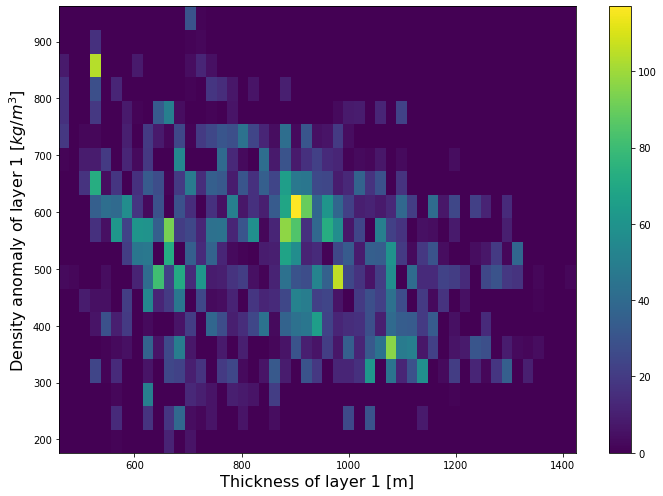

In [ ]:
# Creating dataset
x_2 = models_2[burnin_time:,7]
y_2 = models_2[burnin_time:,8]
  
# Creating bins
x_min_2 = np.min(x_2)
x_max_2 = np.max(x_2)
  
y_min_2 = np.min(y_2)
y_max_2 = np.max(y_2)
  
x_bins_2 = np.linspace(x_min_2, x_max_2, 50)
y_bins_2 = np.linspace(y_min_2, y_max_2, 20)
  
fig, ax = plt.subplots(figsize =(10, 7))
# Creating plot
plt.hist2d(x_2, y_2, bins =[x_bins_2, y_bins_2])
#h = ax.hist2d(x, y, bins =[x_bins, y_bins])

ax.set_xlabel('Thickness of layer 1 [m]',fontsize=16) 
ax.set_ylabel('Density anomaly of layer 1 $[kg/m^3]$',fontsize=16) 

#im = ax.imshow(x,y)
#fig.colorbar(h, ax=ax)
plt.colorbar()

# show plot
plt.tight_layout() 
plt.show()

In [ ]:
print('Correlation:',np.corrcoef(x_2,y_2)[1,0])

Correlation: -0.29830762715430437
